In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [16]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device) My laptop uses cpu

#Download MNIST dataset in local system
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

loaders = {
    'train' :   torch.utils.data.DataLoader(train_data,
                                            batch_size = 100,
                                            shuffle=True
                                           ),
    'test'  :   torch.utils.data.DataLoader(test_data,
                                            batch_size = 100,
                                            shuffle=True
                                            )
}

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x   # return x for visualization
cnn = CNN()

In [18]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=20,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(20, 40, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(40 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x   # return x for visualization

cnn1 = CNN1()

In [19]:
from torch.autograd import Variable

In [20]:
def train(num_epochs, model, loaders, optimizer):
    max_epoch = num_epochs  
    Train_loss = 0
    model.train()
    loss_func = nn.CrossEntropyLoss()  
    total_step = len(loaders['train'])
    epoch_arr, loss_arr = [], []
    not_converged = True
    epoch = 0
    grad_arr = []
    while not_converged:
        epoch +=1
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)
            b_y = Variable(labels)
            # or use data, target = Variable(images), Variable(labels)
            output = model(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()

            #apply gradients
            optimizer.step()
        
            Train_loss += loss.item() 
            
        epoch_arr.append(epoch)
        Train_loss /= len(loaders['train'])
        loss_arr.append(Train_loss)
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        grad_arr.append(grad_norm)
        
        if epoch % 1 == 0:
            print(f'epoch : {epoch}, loss = {Train_loss:.4f}')
            
        if epoch == max_epoch:
            print("Max Epoch Reached")
            not_converged = False

        elif (epoch > 5) and  (loss_arr[-1] < 0.001):
            if abs(loss_arr[-3] - loss_arr[-2]) < 1.0e-05 and abs(loss_arr[-2] - loss_arr[-1]) < 1.0e-05:
                print("Convergence reached for loss:",loss_arr[-1])
                not_converged = False
    return epoch_arr, loss_arr, grad_arr
                

In [21]:
def test(model):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    test_loss = 0
    n_correct = 0
    n_samples = 0
    with torch.no_grad():
        for images, labels in loaders['test']:
            test_output, last_layer = model(images)
            test_loss += loss_fn(test_output, labels).data
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            n_samples += labels.size(0)
            n_correct += (pred_y == labels).sum().item()
            accuracy= 100.0 * n_correct / n_samples
#            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    test_loss /= len(loaders['test'])
    print(accuracy)
#    print(len(loaders['test']))
#            print('Test Accuracy of the model on the 10000 test image: %.2f' % accuracy)
#    print(accuracy, (pred_y == labels).sum().item(), float(labels.size(0)))
    return accuracy

In [22]:
num_epochs = 50

optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.001)
Epoch, Loss, Grad = train(num_epochs, cnn, loaders, optimizer)

# optimizer = torch.optim.Adam(cnn1.parameters(), lr = 0.01)
# loss_acc1 = train(num_epochs, cnn1, loaders, optimizer)
# L1 = np.array(loss_acc1)

epoch : 1, loss = 0.2430
epoch : 2, loss = 0.0667
epoch : 3, loss = 0.0477
epoch : 4, loss = 0.0382
epoch : 5, loss = 0.0322
epoch : 6, loss = 0.0268
epoch : 7, loss = 0.0232
epoch : 8, loss = 0.0195
epoch : 9, loss = 0.0170
epoch : 10, loss = 0.0147
epoch : 11, loss = 0.0139
epoch : 12, loss = 0.0108
epoch : 13, loss = 0.0102
epoch : 14, loss = 0.0077
epoch : 15, loss = 0.0076
epoch : 16, loss = 0.0067
epoch : 17, loss = 0.0076
epoch : 18, loss = 0.0054
epoch : 19, loss = 0.0042
epoch : 20, loss = 0.0043
epoch : 21, loss = 0.0042
epoch : 22, loss = 0.0039
epoch : 23, loss = 0.0036
epoch : 24, loss = 0.0050
epoch : 25, loss = 0.0026
epoch : 26, loss = 0.0037
epoch : 27, loss = 0.0024
epoch : 28, loss = 0.0013
epoch : 29, loss = 0.0036
epoch : 30, loss = 0.0051
epoch : 31, loss = 0.0021
epoch : 32, loss = 0.0005
epoch : 33, loss = 0.0001
epoch : 34, loss = 0.0000
epoch : 35, loss = 0.0000
epoch : 36, loss = 0.0000
epoch : 37, loss = 0.0085
epoch : 38, loss = 0.0049
epoch : 39, loss = 0.

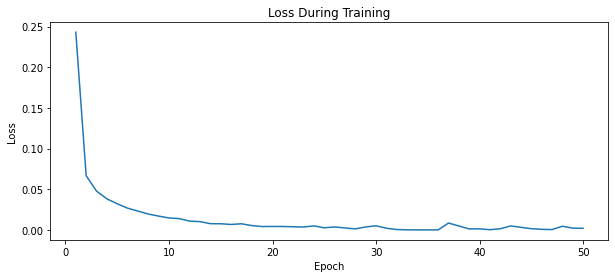

In [23]:
fig = plt.figure(figsize=(10,4))
plt.plot(Epoch, Loss)
plt.title('Loss During Training')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

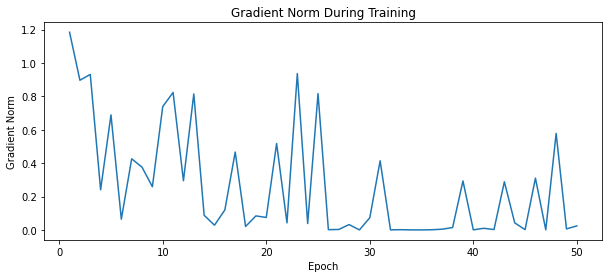

In [24]:
fig = plt.figure(figsize=(10,4))
plt.plot(Epoch, Grad)
plt.title('Gradient Norm During Training')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.show()